In [1]:
%load_ext autoreload
%autoreload 2

import collections
import logging
import os
import pathlib

import numpy as np
import pandas as pd

import core.config as cconfig
import core.finance as cfina
import core.model_evaluator as cmodel
import core.model_plotter as modplot
import core.plotting as plot
import core.signal_processing as csigna
import dataflow_lem.futures_returns.pipeline as dlfrp
import helpers.dbg as dbg
import helpers.env as henv
import helpers.io_ as hio
import helpers.pickle_ as hpickl
import helpers.printing as hprint

from typing import Any, Dict, Iterable, Optional

from tqdm.auto import tqdm

In [2]:
dbg.init_logger(verbosity=logging.INFO)

_LOG = logging.getLogger(__name__)

_LOG.info("%s", henv.get_system_signature()[0])

hprint.config_notebook()

# Packages
         python: 3.7.6
       gluonnlp: 0.9.1
        gluonts: 0.5.0
         joblib: 0.15.1
          mxnet: 1.6.0
          numpy: 1.17.5
         pandas: 1.0.3
        pyarrow: 0.17.1
          scipy: 1.4.1
        seaborn: 0.10.1
        sklearn: 0.23.1
    statsmodels: 0.11.1
# Last commits:
  * f2640ec paul     LemTask164: Checkpoint                                            (70 minutes ago) Fri Apr 23 14:53:15 2021  (HEAD -> LemTask164, origin/LemTask164)
  * e30d3f5 paul     LemTask164: Checkpoint                                            (   2 hours ago) Fri Apr 23 13:44:58 2021           
  *   deabae6 Paul     Merge pull request #159 from alphamatic/LemTask158                (  28 hours ago) Thu Apr 22 11:48:32 2021           
  |\  


In [3]:
def load_files(
    dst_dir: str, file_name: str, idxs: Optional[Iterable[int]] = None
) -> Dict[int, Any]:
    """
    Load according to `file_name` extension.

    Assumes subdirectories withing `dst_dir` have the following structure:
    > /dst_dir/{$RESULT_DIR_NAME}_%i/file_name
    Here `%i` denotes an integer encoded in the subdirectory name.

    The function returns the contents of the files, indexed by the integer
    extracted from the subdirectory index name.

    :param dst_dir: directory containing subdirectories of run results
    :param file_name: the file name within each run results subdirectory to
        load
    :param idxs: specific indices to load; if `None`, loads all indices
    """
    # Retrieve all subdirectories in `dst_dir`.
    p = pathlib.Path(dst_dir)
    subfolders = [f for f in p.iterdir() if f.is_dir()]
    # Order experiment subfolders by number of experiment.
    subfolders_num = {}
    keys = []
    for sf in subfolders:
        key = int(sf.parts[-1].split("_")[-1])
        subfolders_num[key] = sf
        keys.append(key)
    # Ensure there are no duplicate integer keys (e.g., due to an inconsistent
    # subdirectory naming scheme).
    dbg.dassert_no_duplicates(
        keys, "Duplicate keys detected! Check subdirectory names."
    )
    # Specify indices of files to load.
    if idxs is None:
        iter_keys = sorted(keys)
    else:
        idxs_l = set(idxs)
        dbg.dassert_is_subset(idxs_l, set(keys))
        iter_keys = [key for key in sorted(keys) if key in idxs_l]
    # Iterate over experiment subfolders.
    results = collections.OrderedDict()
    for key in tqdm(iter_keys):
        subfolder = subfolders_num[key]
        path_to_file = os.path.join(dst_dir, subfolder, file_name)
        if not os.path.exists(path_to_file):
            _LOG.warning("File `%s` does not exist.", path_to_file)
            continue
        # Load pickle files.
        if file_name.endswith(".pkl"):
            res = hpickl.from_pickle(
                path_to_file, log_level=logging.DEBUG, verbose=False
            )
        # Load json files.
        elif file_name.endswith(".json"):
            with open(path_to_file, "r") as file:
                res = json.load(file)
        # Load txt files.
        elif file_name.endswith(".txt"):
            res = hio.from_file(path_to_file)
        else:
            raise ValueError(f"Unsupported file type='{file_name}'")
        results[key] = res
    return results


def get_config_diffs(
    config_dict: collections.OrderedDict, tag_col: Optional[str] = None
) -> pd.DataFrame:
    """
    Create a dataframe of config diffs.

    :param config_dict: dictionary of configs
    :param tag_col: name of the tag col. If tags are the same for all configs
        and `tag_col` is not None, add tags to config diffs dataframe
    :return: config diffs dataframe
    """
    diffs = cconfig.diff_configs(config_dict.values())
    non_empty_diffs = [diff for diff in diffs if len(diff) > 1]
    if non_empty_diffs:
        config_diffs = cconfig.convert_to_dataframe(diffs).dropna(
            how="all", axis=1
        )
    else:
        config_diffs = pd.DataFrame(index=range(len(diffs)))
    # If tags are the same, still add them to `config_diffs`.
    if tag_col is not None and tag_col not in config_diffs.columns:
        tags = [config[tag_col] for config in config_dict.values()]
        config_diffs[tag_col] = tags
    return config_diffs

# Load ERH1 results

In [4]:
exp_dir = "/Users/paul/src/alphamatic/lem/experiments/erh1_experiments/run1"

In [5]:
rbs = load_files(exp_dir, "result_bundle.pkl")

File `/Users/paul/src/alphamatic/lem/experiments/erh1_experiments/run1/result_123/result_bundle.pkl` does not exist.
File `/Users/paul/src/alphamatic/lem/experiments/erh1_experiments/run1/result_125/result_bundle.pkl` does not exist.
File `/Users/paul/src/alphamatic/lem/experiments/erh1_experiments/run1/result_140/result_bundle.pkl` does not exist.



In [8]:
rbs[0]["result_df"].head()

,vwap,twap,twap_ret_0,vwap_ret_0,vwap_ret_0_vol,vwap_ret_0_vol_2,vwap_ret_0_vol_2_hat,vwap_ret_0_zscored,1,2,3,4,5,6,vwap_ret_0_zscored_2,vwap_ret_0_zscored_2_hat
datetime,,,,,,,,,,,,,,,,
2015-06-15 09:35:00,281.636470,281.410,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-06-15 09:40:00,280.643460,280.440,-0.003447,-0.003526,0.003526,0.002022,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-06-15 09:45:00,281.064233,280.855,0.001480,0.001499,0.001499,0.002631,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-06-15 09:50:00,280.495842,280.718,-0.000488,-0.002022,0.002022,0.000333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-06-15 09:55:00,279.757906,279.760,-0.003413,-0.002631,0.002631,0.002873,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
def get_rets_and_preds(rbs):
    rets = {}
    preds = {}
    for key, rb in rbs.items():
        df = rb["result_df"]
        rets[key] = df["vwap_ret_0_zscored_2"]
        preds[key] = df["vwap_ret_0_zscored_2_hat"]
    return rets, preds

In [10]:
rets, preds = get_rets_and_preds(rbs)

In [11]:
evaluator = cmodel.ModelEvaluator(
    returns=rets,
    predictions=preds,
    target_volatility=0.1,
    oos_start="2017-12-30",
)
plotter = modplot.ModelPlotter(evaluator)

All-NaN out-of-sample for `k`=3
All-NaN out-of-sample for `k`=5
All-NaN out-of-sample for `k`=11
All-NaN out-of-sample for `k`=22
All-NaN out-of-sample for `k`=24
All-NaN out-of-sample for `k`=38
All-NaN out-of-sample for `k`=43
All-NaN out-of-sample for `k`=49
All-NaN out-of-sample for `k`=51
All-NaN out-of-sample for `k`=52
All-NaN out-of-sample for `k`=61
All-NaN in-sample for `k`=62
All-NaN out-of-sample for `k`=64
All-NaN out-of-sample for `k`=72
All-NaN out-of-sample for `k`=73
All-NaN out-of-sample for `k`=86
All-NaN out-of-sample for `k`=90
All-NaN out-of-sample for `k`=96
All-NaN out-of-sample for `k`=103
All-NaN out-of-sample for `k`=111
All-NaN out-of-sample for `k`=116
All-NaN out-of-sample for `k`=120
All-NaN out-of-sample for `k`=128
All-NaN out-of-sample for `k`=131
All-NaN out-of-sample for `k`=132
All-NaN in-sample for `k`=136
All-NaN in-sample for `k`=139
All-NaN out-of-sample for `k`=144
All-NaN out-of-sample for `k`=148
All-NaN out-of-sample for `k`=161
All-NaN out-

In [12]:
evaluator.calculate_stats()

,0,1,2,4,6,7,8,9,10,12,13,14,15,16,17,18,19,20,21,23,25,26,27,28,29,30,31,32,33,34,35,36,37,39,40,41,42,44,45,46,47,48,50,53,54,55,56,57,58,59,60,63,65,66,67,68,69,70,71,74,75,76,77,78,79,80,81,82,83,84,85,87,88,89,91,92,93,94,95,97,98,99,100,101,102,104,105,106,107,108,109,110,112,113,114,115,117,118,119,121,122,124,126,127,129,130,133,134,135,137,138,141,142,143,145,146,147,149,150,151,152,153,154,155,156,157,158,159,160,162,163,164,165,166,168,170,171,172,173,174,175,176,177,178,179,180,181,182,183,185,186,187,189,190,191,192,193,194,195,196,198
sharpe_ratio,1.65363,1.20981,1.48433,2.32703,0.969411,0.584417,1.57672,0.691685,0.416553,1.94612,1.48583,1.52037,1.77621,1.07601,1.52283,1.12411,1.01266,1.64251,-0.551435,0.628387,1.35531,1.05107,0.977105,1.73606,1.4238,0.443309,1.99781,1.55208,0.802264,1.26557,1.36389,2.55827,0.913376,1.23726,1.16815,1.31325,1.16306,1.16873,0.760909,2.00501,2.90924,0.677456,1.43886,1.06524,1.87713,1.21257,1.26462,1.41848,0.924781,1.30851,0.452215,1.63028,1.49412,2.04408,0.961379,2.01416,0.567299,1.72136,1.09352,0.102698,0.776086,0.529516,2.00145,1.58838,3.46796,1.00972,1.91235,1.43345,2.25967,0.71199,2.33909,1.85518,1.97886,1.65585,0.770808,0.789927,1.08977,0.646058,1.88816,1.88416,1.99178,1.19407,0.987137,1.51321,0.879243,1.59095,1.13972,0.921452,0.815924,0.830637,1.7424,1.98713,1.65198,1.36873,0.116696,1.90074,1.79538,0.627874,0.720905,0.577598,1.16048,1.52165,1.13767,0.16719,1.11116,0.474282,0.92945,0.530614,2.24469,1.29765,0.859032,2.89331,0.0333675,1.62236,2.0336,0.149481,0.730016,1.35244,1.13824,1.98868,0.922263,1.01183,0.957914,0.583486,1.72572,1.5139,0.820756,1.82105,0.855392,1.59943,0.818687,0.619725,1.78236,1.12705,1.59924,0.767348,1.28662,1.73104,1.716,0.897648,2.30723,0.983696,1.64317,0.634355,0.492926,1.32446,1.04758,1.23942,1.27239,0.681281,1.6308,0.865158,1.03034,0.89019,0.81929,1.1378,0.124145,1.52549,1.16639,0.0497534,1.68018
sharpe_ratio_standard_error,0.626724,0.353759,0.353761,0.353761,0.35376,0.353759,0.353758,0.35376,0.353756,0.353761,0.353758,0.353758,0.353762,0.353751,0.353762,0.353757,0.353757,0.353758,0.629824,0.353756,0.353757,0.35376,0.353757,0.353758,0.353757,0.35376,0.353763,0.353758,0.353756,0.353761,0.353759,0.353761,0.353753,0.353757,0.353761,0.353761,0.353757,0.353759,0.353756,0.35375,0.353767,0.35376,0.414656,0.35376,0.353759,0.353761,0.353755,0.353761,0.353756,0.353757,0.353756,0.353758,0.353758,0.353763,0.35376,0.353759,0.353757,0.353758,0.353758,0.353756,0.35376,0.353756,0.353759,0.353762,0.469621,0.353758,0.353763,0.353748,0.35376,0.353756,0.35376,0.353759,0.353756,0.353761,0.353758,0.353756,0.353757,0.353753,0.353759,0.353761,0.353759,0.353756,0.353757,0.353761,0.35376,0.353758,0.353757,0.35376,0.353757,0.353756,0.353758,0.353758,0.353758,0.353758,0.353756,0.353759,0.353757,0.353756,0.353757,0.353754,0.353761,0.353757,0.353757,0.353755,0.353759,0.353756,0.353753,0.353756,0.353756,0.353759,0.35376,0.353762,0.353756,0.353762,0.353759,0.35376,0.353752,0.353757,0.353759,0.353759,0.35376,0.353757,0.353757,0.353757,0.353758,0.353761,0.35376,0.353759,0.353755,0.353758,0.353758,0.353756,0.353757,0.353757,0.353758,0.353756,0.353748,0.353762,0.353762,0.353756,0.353757,0.353757,0.353758,0.353756,0.35376,0.353761,0.353757,0.353757,0.353761,0.353756,0.353758,0.353757,0.353757,0.353756,0.353756,0.353757,0.353756,0.353758,0.353761,0.35376,0.35375
tval,2.6388,3.42005,4.19621,6.57884,2.74039,1.65203,4.45744,1.95527,1.17752,5.50179,4.20064,4.29815,5.02143,3.04186,4.30501,3.17777,2.86269,4.64345,-0.875534,1.77635,3.83142,2.97126,2.7622,4.90799,4.02514,1.25314,5.64821,4.38785,2.26792,3.5777,3.8558,7.23284,2.58205,3.49771,3.30223,3.71246,3.28786,3.30387,2.15099,5.66899,8.22712,1.91504,3.47022,3.01127,5.30687,3.42783,3.57516,4.0102,2.61425,3.69914,1.27833,4.60904,4.2241,5.77895,2.71775,5.69479,1.60366,4.86672,3.09127,0.290306,2.19387,1.49686,5.65849,4.4904,7.38685,2.8544,5.40642,4.05263,6.38867,2.01269,6.61355,5.24464,5.59458,4.68119,2.17895,2.23301,3.0807,1.82632,5.33803,5.32686,

In [13]:
evaluator.aggregate_models(mode="ins", target_volatility=0.05)[2].to_frame()

,stats
sharpe_ratio,4.5093
sharpe_ratio_standard_error,0.353763
tval,12.7531
pval,3.13592e-37
kratio,1.10883
annualized_mean_return_(%),22.5465
annualized_volatility_(%),5
max_drawdown_(%),-7.01681
start_time,2010-01-04 13:20:00
end_time,2017-12-29 15:50:00


In [14]:
evaluator.aggregate_models(mode="oos")[2].to_frame()

,stats
sharpe_ratio,4.84088
sharpe_ratio_standard_error,0.706864
tval,6.85234
pval,7.38006e-12
kratio,4.04169
annualized_mean_return_(%),25.8117
annualized_volatility_(%),5.33202
max_drawdown_(%),-3.42174
start_time,2018-01-02 09:50:00
end_time,2019-12-30 15:50:00


In [15]:
evaluator.aggregate_models(mode="all_available")[2].to_frame()

,stats
sharpe_ratio,4.4229
sharpe_ratio_standard_error,0.316398
tval,13.9857
pval,2.00901e-44
kratio,1.17343
annualized_mean_return_(%),15.4163
annualized_volatility_(%),3.48556
max_drawdown_(%),-4.04834
start_time,2010-01-04 13:20:00
end_time,2019-12-30 15:50:00


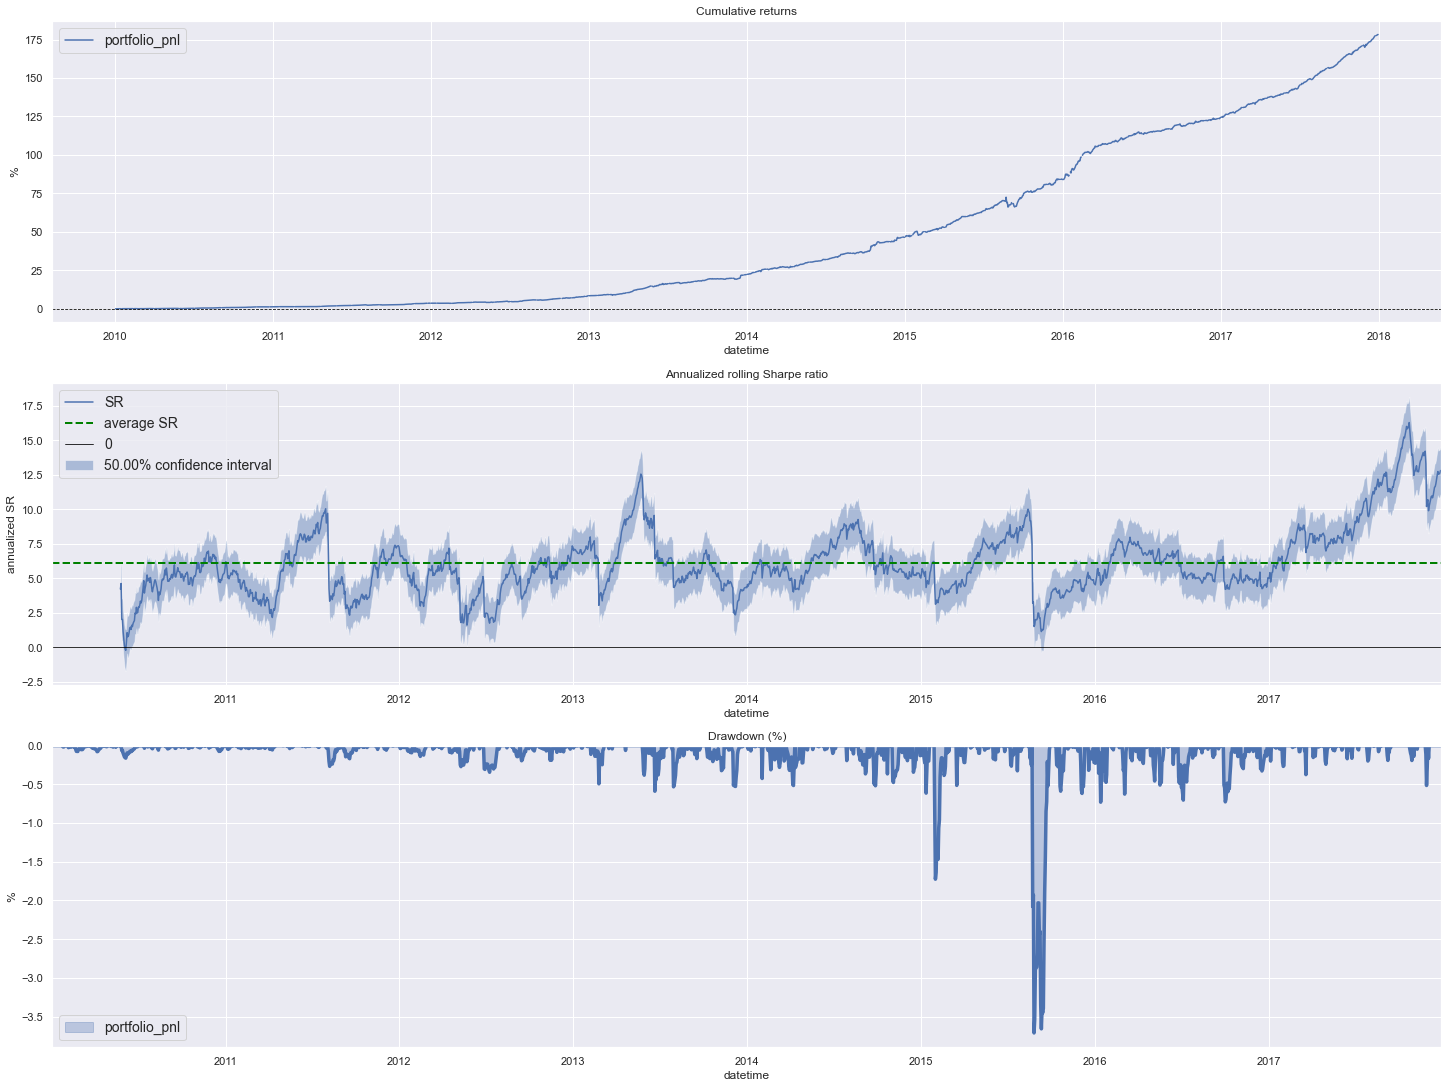

In [16]:
plotter.plot_performance(resample_rule="B")

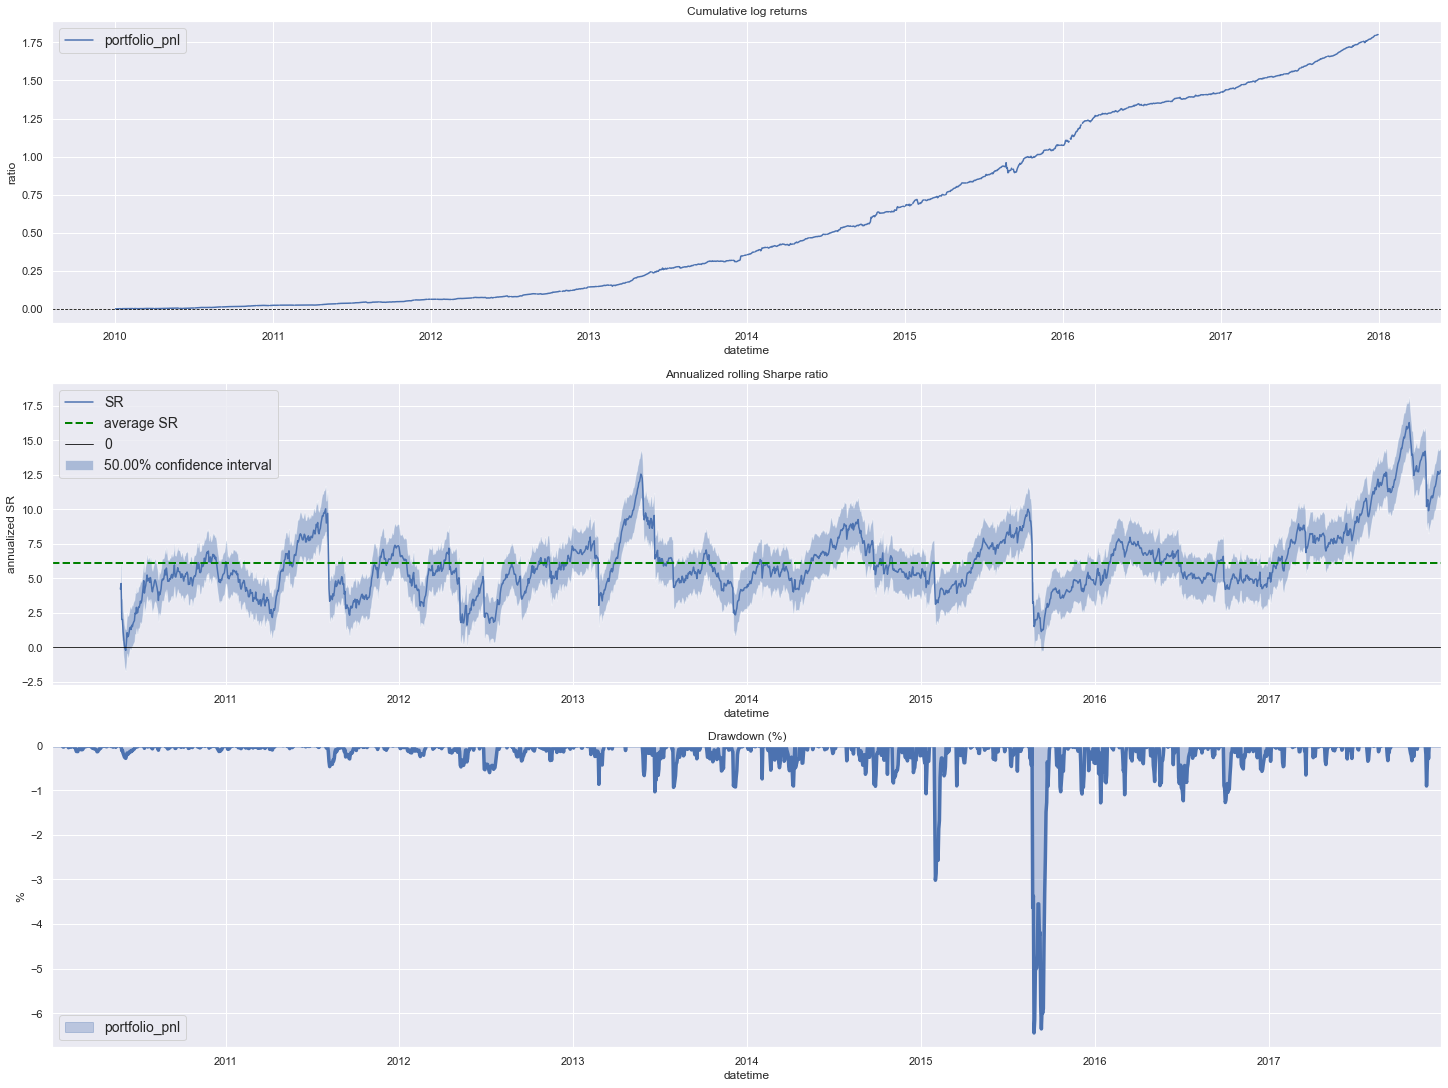

In [17]:
plotter.plot_performance(
    mode="ins",
    target_volatility=0.05,
    resample_rule="B",
    plot_cumulative_returns_kwargs={"mode": "log"},
)

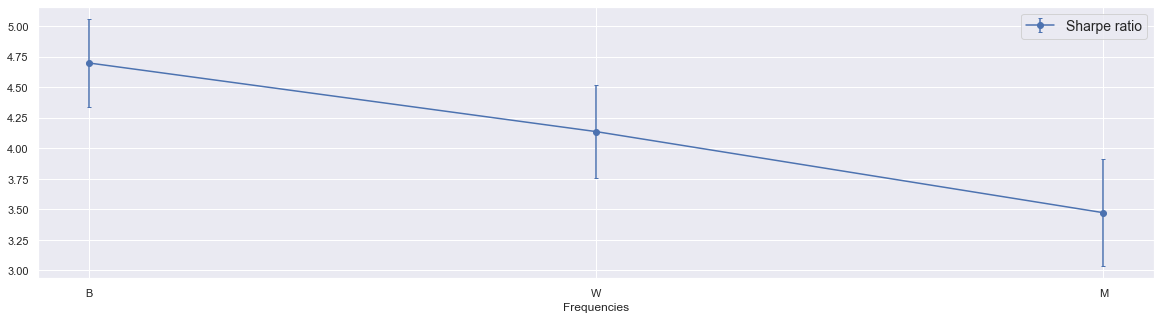

In [18]:
plotter.plot_sharpe_ratio_panel(frequencies=["B", "W", "M"])

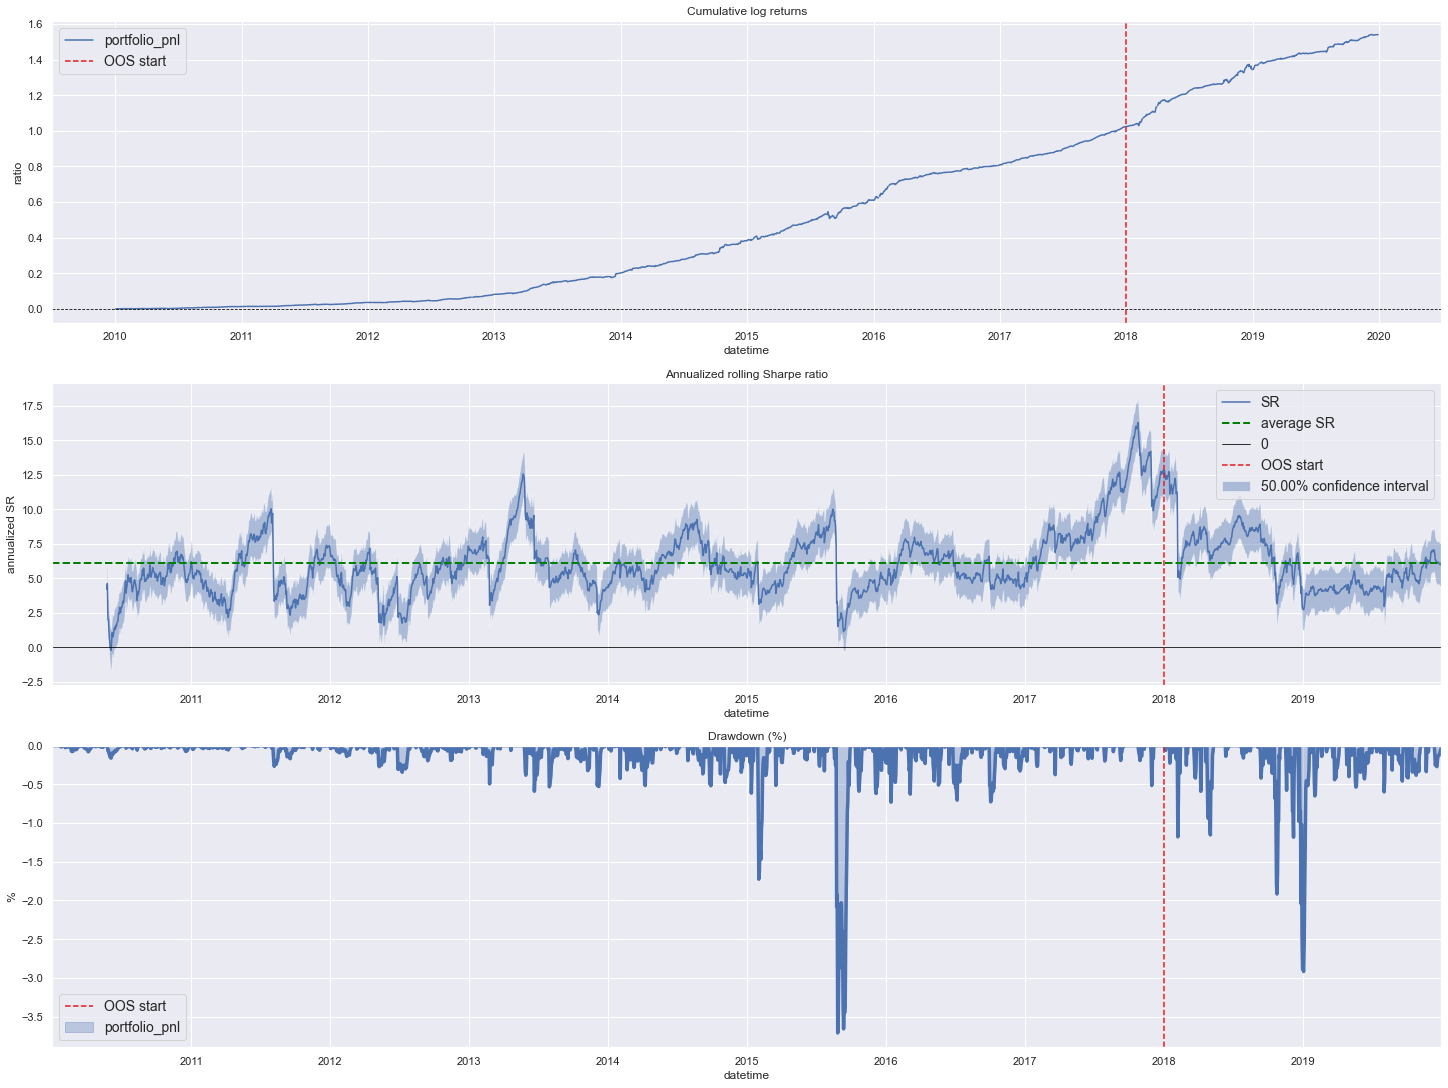

In [20]:
plotter.plot_performance(
    mode="all_available",
    target_volatility=0.05,
    resample_rule="B",
    plot_cumulative_returns_kwargs={"mode": "log"},
)

In [21]:
pnl, pos, stats = evaluator.aggregate_models(mode="all_available", target_volatility=0.05)

# Calculate ES returns (as a proxy for SPY)

In [22]:
rb = dlfrp.ReturnsBuilder()

In [23]:
config = rb.get_config_template()

In [24]:
config["rets/read_data", "source_node_kwargs", "symbol"] = "ES"

In [38]:
config["rets/read_data", "source_node_kwargs", "end_date"] = None

In [39]:
config

rets/read_data:
  source_node_name: kibot
  source_node_kwargs:
    frequency: T
    contract_type: continuous
    symbol: ES
    start_date: 2010-01-04 09:00:00
    end_date: None
rets/filter_ath:
  col_mode: replace_all
  transformer_kwargs:
    start_time: 09:30:00
    end_time: 16:00:00
rets/resample:
  rule: 1T
  price_cols: ['close']
  volume_cols: ['vol']
rets/compute_wap:
  rule: 5T
  price_col: close
  volume_col: vol
rets/compute_ret_0:
  cols: ['twap', 'vwap']
  col_mode: merge_all
  transformer_kwargs:
    mode: pct_change
rets/model_volatility:
  cols: ['vwap_ret_0']
  steps_ahead: 2
  nan_mode: leave_unchanged
rets/clip:
  cols: ['vwap_ret_0_zscored']
  col_mode: replace_selected

In [40]:
dag = rb.get_dag(config, mode="loose")

In [41]:
es_rets = dag.run_leq_node("rets/clip", "fit")["df_out"]

In [42]:
dag.dag.nodes

NodeView(('rets/read_data', 'rets/filter_weekends', 'rets/filter_ath', 'rets/resample', 'rets/compute_wap', 'rets/compute_ret_0', 'rets/model_volatility', 'rets/clip'))

In [43]:
es_rets.head()

,vwap,twap,twap_ret_0,vwap_ret_0,vwap_ret_0_vol,vwap_ret_0_vol_2,vwap_ret_0_vol_2_hat,vwap_ret_0_zscored
datetime,,,,,,,,
2010-01-04 09:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-04 09:05:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-04 09:10:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-04 09:15:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-04 09:20:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [44]:
es_twap_rets = cfina.resample_time_bars(es_rets, "B", return_cols=["twap_ret_0"])["twap_ret_0"]

In [45]:
es_twap_rets.head()

datetime
2010-01-04    0.007166
2010-01-05    0.002884
2010-01-06    0.001330
2010-01-07    0.005606
2010-01-08    0.005192
Freq: B, Name: twap_ret_0, dtype: float64

In [46]:
es_twap = es_twap_rets.cumsum()

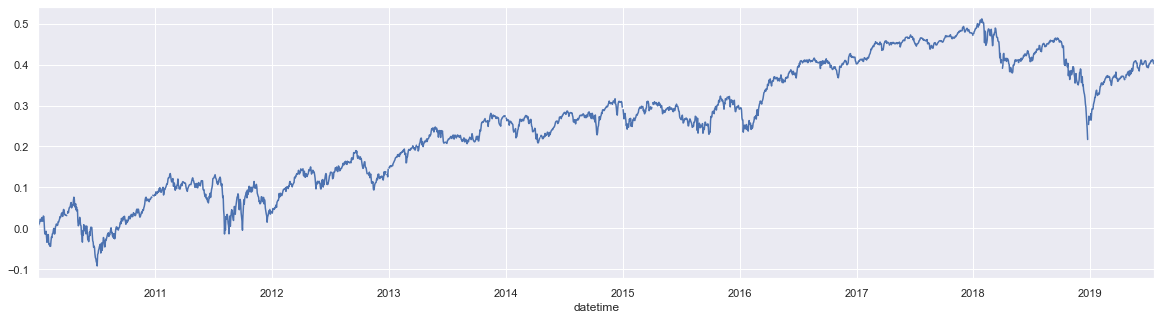

In [47]:
es_twap.plot()

# Calculate correlation of portfolio with ES

In [48]:
pnl_srs = pnl.resample("B").sum(min_count=1)

In [49]:
pnl_srs.head()

datetime
2010-01-04   -8.709003e-06
2010-01-05    6.790626e-07
2010-01-06    1.440596e-05
2010-01-07   -1.291042e-05
2010-01-08    5.705263e-05
Freq: B, Name: portfolio_pnl, dtype: float64

In [50]:
{shift: es_twap_rets.corr(pnl_srs.shift(shift)) for shift in list(range(-7, 8, 1))}

{-7: -0.026241373292332688,
 -6: -0.04162346015909028,
 -5: 0.07196161025889247,
 -4: -0.0563480632337401,
 -3: -0.047527473508718734,
 -2: 0.027412682005770055,
 -1: -0.013726104111027254,
 0: 0.00378876394182784,
 1: -0.03918906155242407,
 2: 0.026703643282407284,
 3: -0.02209634425828082,
 4: 0.018011336555192572,
 5: -0.017930524587534767,
 6: 0.01604467787192045,
 7: -0.00894440503817305}

In [51]:
pnl_srs.shift(-2)

datetime
2010-01-04    0.000014
2010-01-05   -0.000013
2010-01-06    0.000057
2010-01-07    0.000080
2010-01-08    0.000025
                ...   
2019-12-24    0.000524
2019-12-25   -0.000015
2019-12-26    0.000414
2019-12-27         NaN
2019-12-30         NaN
Freq: B, Name: portfolio_pnl, Length: 2606, dtype: float64

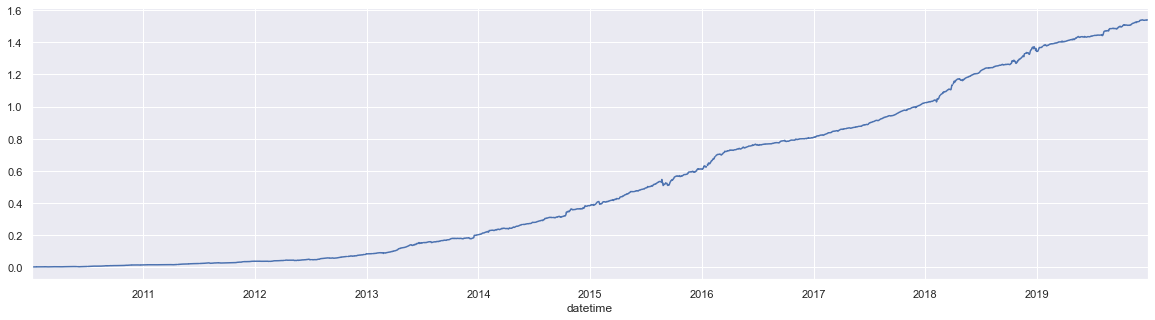

In [52]:
pnl_srs.cumsum().plot()

In [53]:
es_twap_rets.corr(pnl_srs)

0.00378876394182784

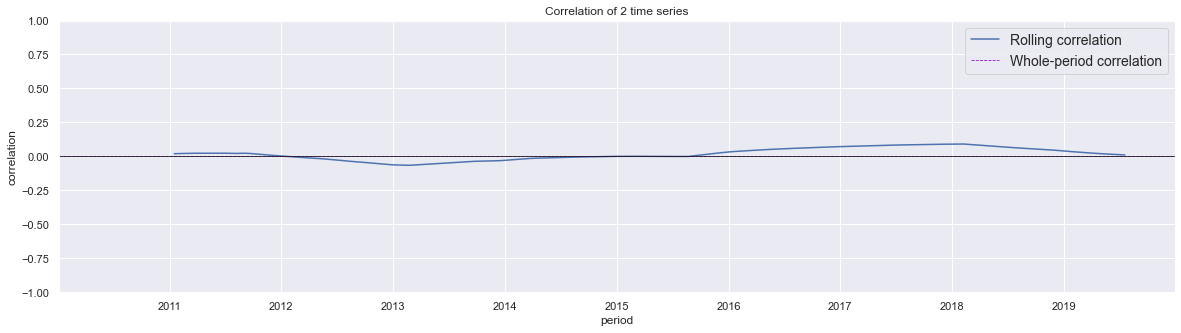

In [54]:
plot.plot_rolling_correlation(
    srs1=es_twap_rets,
    srs2=pnl_srs.shift(0),
    demean=False,
    tau=365,
    min_periods=90,
    min_depth=2,
    max_depth=3,
    ylim="fixed")

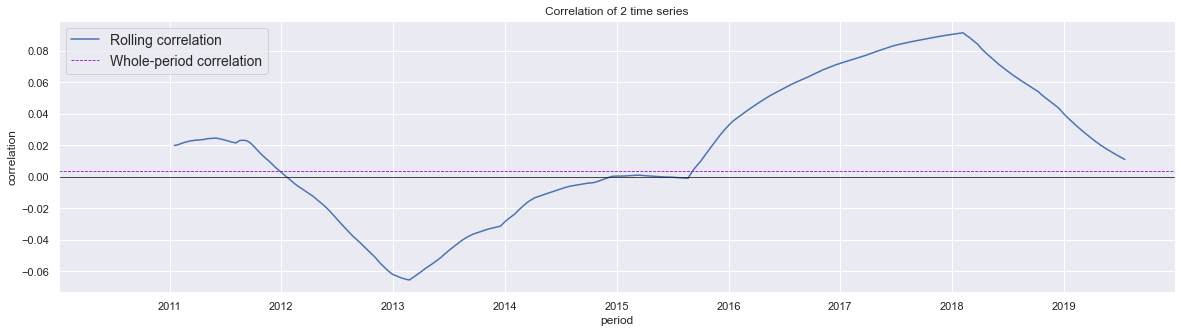

In [55]:
plot.plot_rolling_correlation(
    srs1=es_twap_rets,
    srs2=pnl_srs.shift(0),
    demean=False,
    tau=365,
    min_periods=90,
    min_depth=2,
    max_depth=3,
)

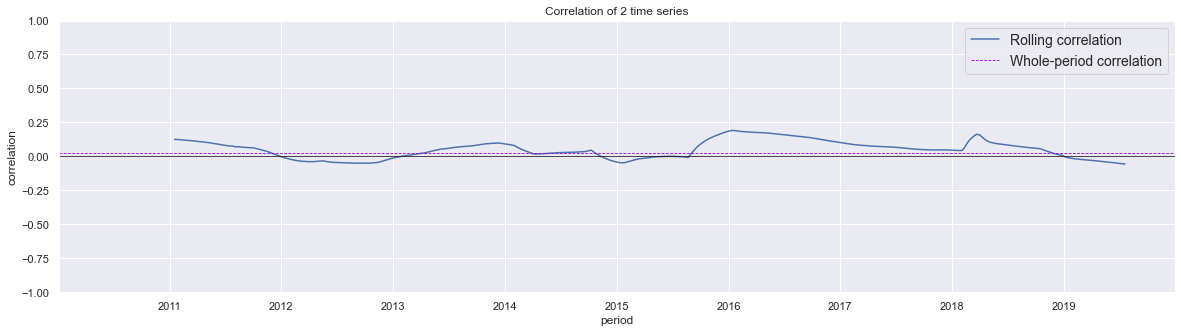

In [56]:
plot.plot_rolling_correlation(
    srs1=es_twap_rets,
    srs2=pnl_srs.shift(-2),
    demean=False,
    tau=365/4,
    min_periods=90,
    min_depth=2,
    max_depth=3,
    ylim="fixed"
)

In [57]:
csigna.compute_rolling_corr(
    es_twap_rets,
    pnl_srs,
    tau=10
).dropna()

datetime
2010-01-05   -1.000000
2010-01-06   -0.938442
2010-01-07   -0.915455
2010-01-08   -0.057560
2010-01-11   -0.677943
                ...   
2019-07-15   -0.071413
2019-07-16    0.017772
2019-07-17   -0.146730
2019-07-18   -0.250458
2019-07-19   -0.211141
Freq: B, Length: 2489, dtype: float64

# Analyze portfolio exposure

In [58]:
pnl, pos, stats = evaluator.aggregate_models(mode="all_available")

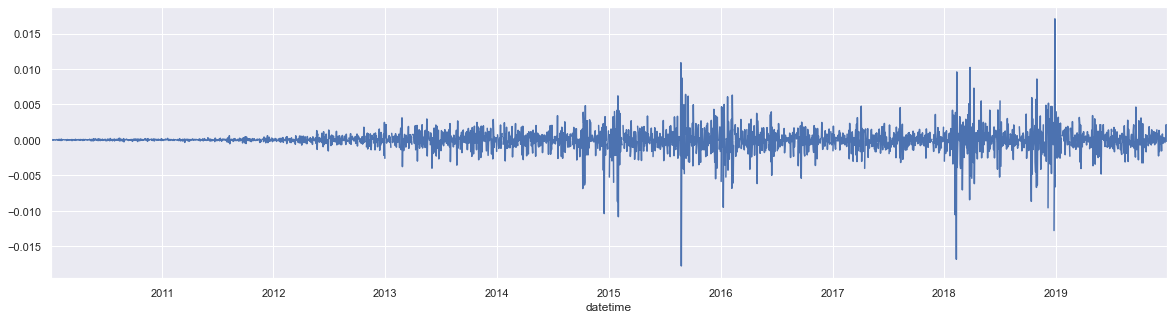

In [59]:
pos.resample("B").sum(min_count=1).plot()

In [60]:
preds_daily = {k: preds[k].resample("B").sum(min_count=1) for k in preds.keys()}

In [61]:
df = pd.DataFrame.from_dict(preds_daily)

In [62]:
## Weights in proportion to signal strength, equally weighted across equities

In [63]:
df.mean(axis=1).max()

0.24817945570312644

In [64]:
df.mean(axis=1).abs().mean()

0.019155267813412813

In [65]:
df.mean(axis=1).mean()

-0.00043010665556191566

In [66]:
df.mean(axis=1).min()

-0.24252246777756994

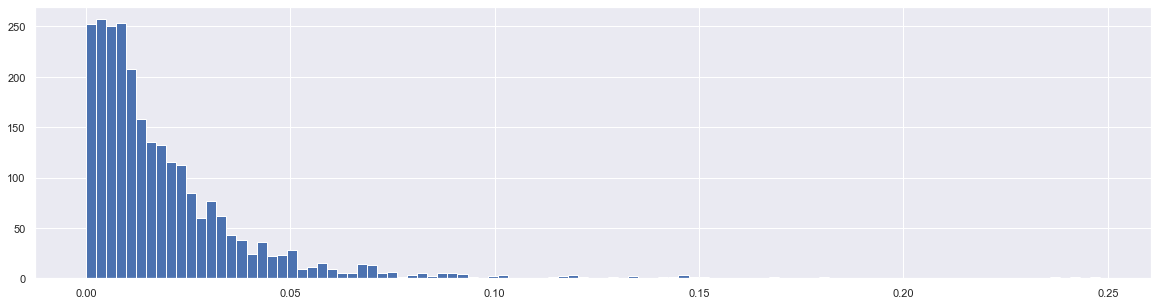

In [67]:
df.mean(axis=1).abs().hist(bins=101)

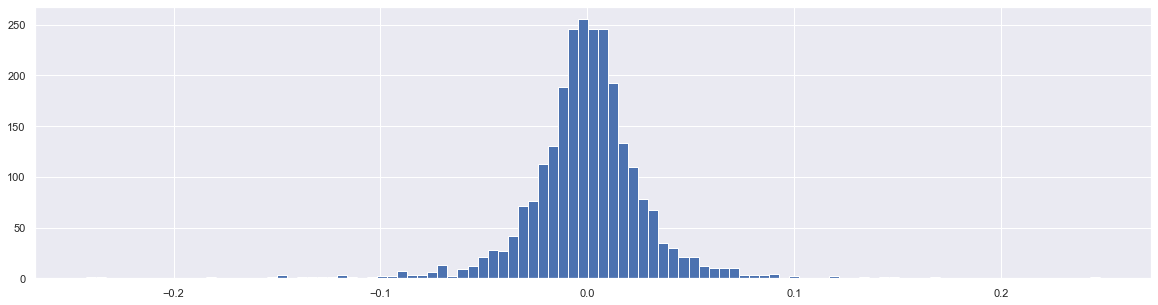

In [68]:
df.mean(axis=1).hist(bins=101)

In [69]:
## Weight equally by equity, but ignore signal strength

In [70]:
df_pos = (df > 0).astype(int)

In [71]:
df_neg = -1*(df < 0).astype(int)

In [72]:
df_preds = df_pos + df_neg

In [73]:
df_preds.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,124,126,127,128,129,130,131,132,133,134,135,136,137,138,139,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199
datetime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2010-01-04,0,0,0,0,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,0,0,0,0,0,0,0,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,0,0
2010-01-05,0,0,0,0,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2010-01-06,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2010-01-07,0,0,0,0,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,-1,0,0,0,0,0,0,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2010-01-08,0,0,0,0,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,0,0,0,0,0,0,0,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,0,0,0,0,0,0,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,0,0,0,0,1,0,0,0,0,0,0,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,0,0


In [74]:
signed_bets = df_preds.sum(axis=1)

In [75]:
signed_bets.head()

datetime
2010-01-04   -3
2010-01-05    1
2010-01-06    5
2010-01-07    5
2010-01-08   -9
Freq: B, dtype: int64

In [76]:
bets = df_preds.apply(abs).sum(axis=1)

In [77]:
bets.head()

datetime
2010-01-04    11
2010-01-05    11
2010-01-06    11
2010-01-07    11
2010-01-08    11
Freq: B, dtype: int64

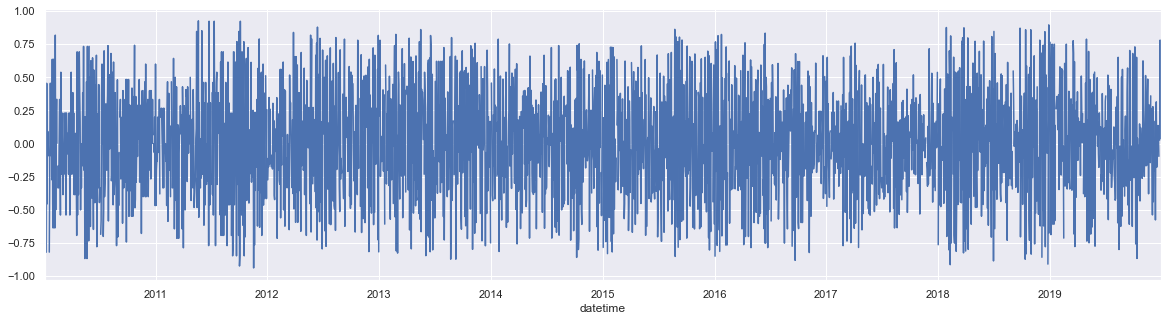

In [78]:
(signed_bets / bets).plot()

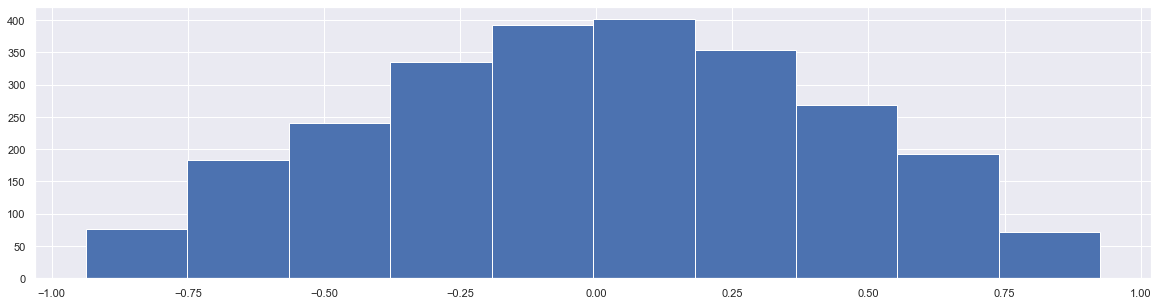

In [79]:
(signed_bets / bets).hist(bins=10)